In [1]:
import pandas as pd
import numpy as np

import datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings 
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
sns.set_style('darkgrid')

# **Load Dataset**

In [3]:
vehicles_df = pd.read_csv('../dataset/motorcycle_profile.csv')
trips_df = pd.read_csv('../dataset/trips.csv')
users_df = pd.read_csv('../dataset/user_profile.csv')

merged_df = pd.merge(vehicles_df, users_df, left_on='borrower_id', right_on='user_id', how='outer')
merged_df = pd.merge(merged_df, trips_df, left_on='vehicle_id', right_on='vehicle_id', how='outer')

In [4]:
# Skimming data
def skimming(df):
    df_info = pd.DataFrame({
                    'feature': df.columns.values,
                    'data_type': df.dtypes.values,
                    'null_value(%)': df.isna().mean().values * 100,
                    'neg_value(%)': [len(df[col][df[col] < 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],
                    '0_value(%)': [len(df[col][df[col] == 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],
                    'duplicate' : df.duplicated().sum(),
                    'n_unique': df.nunique().values,
                    'sample_unique': [df[col].unique() for col in df.columns]}
                ).round(3)
    return df_info

def elbow_visualizer(model, data, metric, k=(2,8), timings=True, locate_point=True, show_value=False):
    sns.set_style('whitegrid')
    
    visualizer = KElbowVisualizer(model, k=k, metric=metric, timings=timings, locate_elbow=locate_point)
    visualizer.fit(data)
    
    if show_value is True:
        display(pd.DataFrame({
            'k-Value': visualizer.k_values_,
            f'{metric.title()} Score': visualizer.k_scores_,
            'Times (second)': visualizer.k_timers_
        }))
    
    # Show the elbow plot
    visualizer.show()

def plot_cluster(data, cluster, suptitle, plot_3d=False, hue_order=None, size=None, sizes=None, size_order=None):

    if plot_3d is True:
        # Creating a 3D scatter plot using Plotly
        fig = px.scatter_3d(data, x='recency', y='frequency', z='monetary', color=cluster, title=suptitle)

        # Adjusting the size of the 3D plot
        fig.update_layout(width=800, height=600)

        # Displaying the 3D plot
        fig.show()
    
    else:
        # Pairs of variables to plot against each other
        vars = [('recency', 'frequency'), ('recency', 'monetary'), ('frequency', 'monetary')]

        # Setting up the figure with specific size
        plt.figure(figsize=(18,5))
        sns.set_style('white')

        # Looping through each pair of variables
        for i, (x, y) in enumerate(vars, 1):
            # Creating a subplot for each pair
            plt.subplot(1, 3, i)
            # Creating a scatter plot for each pair of variables
            sns.scatterplot(data=data, x=x, y=y, hue=cluster, sizes=sizes, size_order=size_order, size=size, hue_order=hue_order, palette='Spectral_r')
            # Setting the title, x-label, and y-label for each plot
            plt.xlabel(x.title())
            plt.ylabel(y.title())

            # Removing the legend for the first two plots to avoid clutter
            if i != 3:
                plt.legend('')
                
        # Placing a single legend outside the last plot
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.suptitle((suptitle), fontsize=16)
        # Adjusting the layout and displaying the plots
        plt.tight_layout()
        plt.show()

In [5]:
print('Total users:', len(merged_df['user_id'].unique()))
print('Total vehicles:', len(merged_df['vehicle_id'].unique()))

Total users: 54
Total vehicles: 95


- There are a total of **54 unique users** and **95 unique vehicles** in the dataset. Since the number of users is relatively small compared to the number of vehicles, the analysis is conducted at the vehicle level rather than the user (rider) level. This approach is valid because each vehicle is associated with only one borrower/user, ensuring that the vehicle-level analysis still accurately reflects individual usage patterns.

# **Modeling**

##  **Features Engineering**

---

Feature engineering is a crucial process in data modeling aimed at improving the quality of features used in statistical or machine learning models. The main goal of feature engineering is to identify, modify, or create features that can assist the model in better understanding and predicting data. The stages in feature engineering modeling include Feature Selection, Handling Missing & Duplicate Value, Feature Extraction, and Normalization (Scaling).

### **Features Selection**

In [5]:
merged_df = merged_df[['vehicle_id', 'trip_id', 'start_trip_timestamp', 'duration']]

The features above can be used for RFM (Recency, Frequency, Monetary) analysis and modeling, in accordance with the description provided:

- `start_trip_timestamp`: This feature can be used to calculate Recency (R) in RFM analysis. By measuring the time difference between the last trip date and a specific reference date (e.g., the analysis date), you can determine how "recent" a rider or vehicle activity is. A smaller Recency value indicates that the customer is more active recently.

- `trip_id`: This feature can be used to calculate Frequency (F) in RFM analysis. We can count the number of trip made by rider by counting the unique occurrences of trip_id. A higher Frequency value indicates that the rider uses the service more frequently, indicating consistent or repeat usage behavior.

- `duration`: This feature can be used to calculate Monetary (M) in RFM analysis. By summing the duration for each rider, we can approximate the rider's overall engagement or usage intensity. A higher Monetary value indicates longer usage time, which may correlate with higher value or dependence on the service.

### **Missing and Duplicate Value**

In [6]:
skimming(merged_df)

,feature,data_type,null_value(%),neg_value(%),0_value(%),duplicate,n_unique,sample_unique
0,vehicle_id,object,0.000,0.0,0.0,0,95,"[ZETA-13122200161408, ZETA-13122200078708, NEO..."
1,trip_id,object,0.023,0.0,0.0,0,46883,"[TRIP-MC13122200161408-2024-06-23-009, TRIP-MC..."
2,start_trip_timestamp,object,0.023,0.0,0.0,0,35971,"[2024-06-23 19:16:00, 2024-06-14 19:26:00, 202..."
3,duration,float64,1.418,0.0,0.0,0,3667,"[5.15, 6.23, 37.92, 16.9, 20.25, 14.43, 7.98, ..."


In [7]:
merged_df.dropna(inplace=True)

- **No Duplicate or Negative Values**: The dataset does not contain duplicate entries or negative values in any of the relevant columns. This suggests a high level of data integrity and consistency.

- **Missing Values**: Some columns contain missing values; however, the proportion is relatively small—less than 2% of the total data. Given the low impact, these missing values can be safely removed without significantly affecting the analysis.

In [8]:
merged_df[merged_df.duplicated(subset=['vehicle_id', 'start_trip_timestamp', 'duration'], keep=False)]

,vehicle_id,trip_id,start_trip_timestamp,duration
5846,ZETA-13122200323608,TRIP-MC13122200323608-2024-06-14-010,2024-06-14 17:46:00,31.37
5907,ZETA-13122200323608,TRIP-MC13122200323608-2024-06-14-011,2024-06-14 17:46:00,31.37
21819,NEOVA-0403240015,TRIP-MH2ACC1HXPJ002088-05/08/2024 04:35-002,2024-05-08 04:35:00,2.00
21970,NEOVA-0403240015,TRIP-MH2ACC1HXPJ002088-08/05/2024 04:35-003,2024-05-08 04:35:00,2.00
39800,ZETA-16052300382211,TRIP-MC16052300382211-2024-06-24-020,2024-06-24 17:14:00,17.00
39954,ZETA-16052300382211,TRIP-MC16052300382211-2024-06-24-019,2024-06-24 17:14:00,17.00
43330,ZETA-16052300280311,TRIP-MC16052300280311-2024-06-18-003,2024-06-18 09:57:00,26.67
43386,ZETA-16052300280311,TRIP-MC16052300280311-2024-06-18-004,2024-06-18 09:57:00,26.67


- While there were no exact row-level duplicates in the dataset, a deeper examination using a subset of key features `vehicle_id`, `start_trip_timestamp`, and `duration` revealed duplicate entries. These duplicates indicate that some trip records share the same vehicle, identical start time, and equal duration, but have different trip_id values. This inconsistency may be attributed to system logging errors or data entry redundancies.

In [9]:
skimming(merged_df)

,feature,data_type,null_value(%),neg_value(%),0_value(%),duplicate,n_unique,sample_unique
0,vehicle_id,object,0.0,0.0,0.0,0,84,"[ZETA-13122200161408, NEOVA-2902240001, NEOVA-..."
1,trip_id,object,0.0,0.0,0.0,0,46229,"[TRIP-MC13122200161408-2024-06-23-009, TRIP-MC..."
2,start_trip_timestamp,object,0.0,0.0,0.0,0,35558,"[2024-06-23 19:16:00, 2024-06-14 19:26:00, 202..."
3,duration,float64,0.0,0.0,0.0,0,3667,"[5.15, 6.23, 37.92, 16.9, 20.25, 14.43, 7.98, ..."


In [10]:
merged_df['start_trip_timestamp'] = pd.to_datetime(merged_df['start_trip_timestamp'])
merged_df['start_trip_timestamp'] = merged_df['start_trip_timestamp'].dt.date
merged_df.sort_values(by=['start_trip_timestamp'], inplace=True)
merged_df.reset_index(drop=True, inplace=True)
merged_df

,vehicle_id,trip_id,start_trip_timestamp,duration
0,NEOVA-0403240010,TRIP-MH2ACC1H6PJ001584-01/09/2024 12:46-029,2024-01-09,9.00
1,NEOVA-0403240009,TRIP-MH2ACC1H9PJ001613-01/09/2024 08:54-014,2024-01-09,41.00
2,NEOVA-0403240009,TRIP-MH2ACC1H9PJ001613-01/09/2024 03:25-003,2024-01-09,5.00
3,NEOVA-0403240025,TRIP-MH2ACC1H1PJ001668-01/09/2024 21:09-001,2024-01-09,81.00
4,NEOVA-0403240009,TRIP-MH2ACC1H9PJ001613-01/09/2024 03:55-007,2024-01-09,40.00
...,...,...,...,...
46224,NEOVA-0403240011,TRIP-MH2ACC1HXPJ001619-30/06/2024 12:41-011,2024-06-30,118.00
46225,ZETA-16052300412111,TRIP-MC16052300412111-2024-06-30-002,2024-06-30,11.70
46226,ZETA-16052300434911,TRIP-MC16052300434911-2024-06-30-029,2024-06-30,17.67
46227,NEOVA-0403240002,TRIP-MH2ACC1H4PJ001745-30/06/2024 03:22-004,2024-06-30,45.00


### **Feature Extraction**

Feature extraction is the process of creating new features from existing ones or transforming the existing features in a dataset to capture more relevant information or reduce dimensionality. In the context of RFM analysis, feature extraction involves transforming the given features into Recency (R), Frequency (F), and Monetary (M) features.

- **Recency**: Recency measures how recently a vehicle was last used for a trip.
- **Frequency**: Frequency measures how often a vehicle has been used over a certain period.
- **Monetary**: Monetary measures the total usage duration of a vehicle.

In [11]:
display(merged_df.head())
print('Total Vehicles:', merged_df['vehicle_id'].nunique())

,vehicle_id,trip_id,start_trip_timestamp,duration
0,NEOVA-0403240010,TRIP-MH2ACC1H6PJ001584-01/09/2024 12:46-029,2024-01-09,9.0
1,NEOVA-0403240009,TRIP-MH2ACC1H9PJ001613-01/09/2024 08:54-014,2024-01-09,41.0
2,NEOVA-0403240009,TRIP-MH2ACC1H9PJ001613-01/09/2024 03:25-003,2024-01-09,5.0
3,NEOVA-0403240025,TRIP-MH2ACC1H1PJ001668-01/09/2024 21:09-001,2024-01-09,81.0
4,NEOVA-0403240009,TRIP-MH2ACC1H9PJ001613-01/09/2024 03:55-007,2024-01-09,40.0


Total Vehicles: 84


In [12]:
print('Last Trip Record:', merged_df['start_trip_timestamp'].max())

# Calculate the next day after the maximum order purchase timestamp to determine the reference date for recency calculation.
max_day = merged_df['start_trip_timestamp'].max() + datetime.timedelta(days=1)

# Group the DataFrame by 'vehicle_id' and aggregate RFM metrics.
rfm_data = merged_df.groupby('vehicle_id').agg(
    last_ride=('start_trip_timestamp', 'max'),  # Calculate the last record date for each user.
    recency=('start_trip_timestamp', lambda x: (max_day - x.max()).days),  # Calculate recency in days.
    frequency=('trip_id', lambda x: x.nunique()),  # Calculate the count of unique trip for each user.
    monetary=('duration', 'sum')  # Calculate the total monetary value for each user.
).reset_index()

rfm_data

Last Trip Record: 2024-06-30


,vehicle_id,last_ride,recency,frequency,monetary
0,NEOVA-0403240001,2024-05-16,46,40,674.00
1,NEOVA-0403240002,2024-06-30,1,1069,29588.00
2,NEOVA-0403240003,2024-06-30,1,1761,36718.00
3,NEOVA-0403240004,2024-05-11,51,343,5611.00
4,NEOVA-0403240006,2024-06-24,7,594,20325.00
...,...,...,...,...,...
79,ZETA-16052300441411,2024-06-26,5,117,1111.09
80,ZETA-16052300462311,2024-06-30,1,216,10207.57
81,ZETA-16052300468111,2024-06-30,1,413,8398.21
82,ZETA-16052300477411,2024-06-30,1,612,6968.24


- The `recency` value is calculated by measuring the time difference (in days) between one day after the latest trip date (i.e., the maximum value in the `start_trip_timestamp` column plus one day) and the most recent trip date for each vehicle. This reflects how recently each vehicle was last used.

- The `frequency` value represents the number of trips made by each vehicle. It is obtained by counting the number of unique `trip_id` entries associated with each vehicle.

- The `monetary` value reflects the total time spent using the vehicle. It is calculated by summing the `duration` of all trips associated with each vehicle.

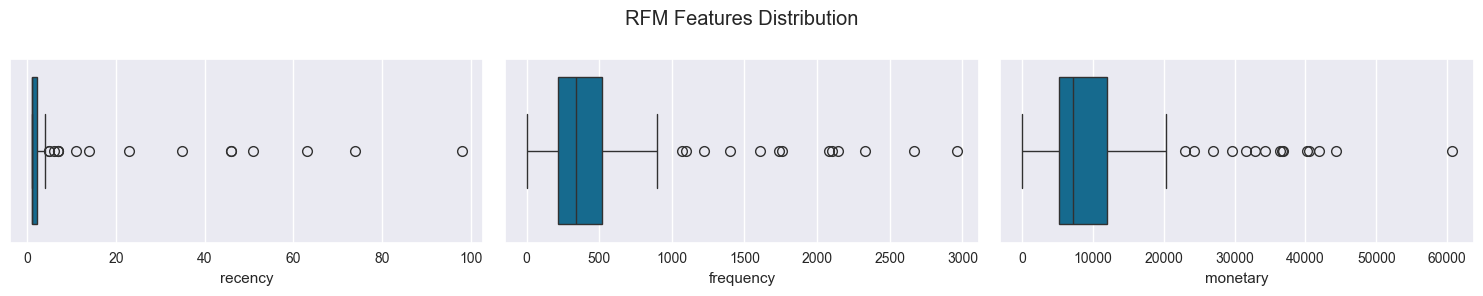

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
recency,84.0,6.928571,17.108996,1.00,1.0000,1.0000,1.000,1.000,1.00,2.25,13.1,46.000,78.08,98.0
frequency,84.0,550.345238,631.286953,1.00,1.0000,9.4000,43.000,215.250,340.50,522.00,1546.9,2098.550,2716.66,2964.0
monetary,84.0,11945.840952,12569.683261,18.52,24.5873,322.2025,856.192,5231.165,7147.93,12006.00,33890.2,39654.504,47073.80,60719.0


In [13]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
index = 0
axs = axs.flatten()
for col, val in rfm_data.select_dtypes(include=[np.number]).items():
    # Create a boxplot for the current column and assign it to the current subplot axis
    sns.boxplot(x=col, data=rfm_data, ax=axs[index])
    index += 1
plt.suptitle('RFM Features Distribution')
plt.tight_layout()
plt.show()

# Generate descriptive statistics for the numerical columns of rfm_data
rfm_data.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

**Recency**:

- Most vehicles have a recency value of 13 days or less, indicating that they were used for a trip relatively recently.

- The distribution is right-skewed, with a few outliers having significantly higher recency values.

- These outliers represent vehicles that have not been used for a longer period, which may indicate `inactive` or `potentially lost users`.

**Frequency**:

- The `frequency distribution is right-skewed`, indicating that most vehicles have a reasonable number of trips, while a few vehicles exhibit extremely high trip counts (exceeding 3,000 trips).

- The presence of these `outliers` suggests that certain vehicles are used far more frequently than others, possibly due to higher demand or more active users.

- The wide `interquartile range (IQR)` highlights a `significant variation in vehicle usage intensity`, indicating that usage patterns differ greatly across the fleet.


**Monetary**:

- The monetary feature, which represents the total usage duration of each vehicle, exhibits a `highly right-skewed distribution`.

- Most vehicles have a total usage duration of `less than 20,000 minutes`, indicating a moderate level of utilization across the fleet.

- However, there are `extreme outliers` with usage durations exceeding `60,000 minutes`, suggesting that a small number of vehicles are used significantly more than others.

**`Insight:`**

- Vehicles with high recency values should be monitored closely, as they may require reactivation strategies or further investigation to understand the cause of inactivity

- Identifying high-frequency vehicles may help uncover key user segments or operational patterns, while low-frequency vehicles may indicate underutilized assets that require further attention.

- Vehicles with extremely high frequency or usage time may need to be checked for maintenance needs or data errors.

### **Normalization (Scalling)**

Normalization (scaling) is a data processing process performed to change the scale or range of data, so that the features have uniform values or are within a specific range. The use of normalization (scaling) prevents bias in machine learning, which is highly sensitive to differences in scale between features. For example, algorithms like K-Means Clustering that rely on distances in their modeling process. Feature normalization or scalling will be done using Standard Scaler.

In [14]:
# Select only the relevant columns ('recency', 'frequency', 'monetary') from rfm_data for scaling.
rfm_data.drop(columns='last_ride', inplace=True)

# Initialize an instance of the StandardScaler, which standardizes features by removing the mean and scaling to unit variance.
scaler = StandardScaler()

# The fit_transform method first calculates the mean and std dev for each feature, then transforms the data.
rfm_scaled = pd.DataFrame(data=scaler.fit_transform(rfm_data[['recency','frequency','monetary']]), columns=['recency', 'frequency', 'monetary'])

rfm_scaled.head()

,recency,frequency,monetary
0,2.297393,-0.813276,-0.902134
1,-0.348599,0.826518,1.411978
2,-0.348599,1.929275,1.982623
3,2.591393,-0.330421,-0.507005
4,0.004200,0.069567,0.670620


## **K-Means Clustering**
---

K-Means Clustering is one of the algorithms in cluster analysis used to group data into clusters based on the similarity of specific features or attributes. The algorithm works by searching for cluster centers (centroids) and assigning data to the cluster with the nearest center.

Here is a more detailed explanation of K-Means Clustering:

- **Initialization**: The K-Means algorithm starts by initializing a certain number of clusters (K) desired by the user. The number K must be determined beforehand.

- **Initial Cluster Centers**: Each cluster is represented by initial centers (centroids) that are randomly chosen or based on some initialization methods like K-Means++.

- **Data Assignment**: The K-Means algorithm assigns each data point to the cluster with the closest center. The cluster centers are updated in each iteration.

- **Calculation of New Centers**: After the initial assignment, new cluster centers are calculated by taking the average of all data points within that cluster. These new centers become the updated centers for their respective clusters.

- **Iteration**: The data assignment and calculation of new centers are repeated several times (iterations) or until specific stopping criteria are met. Typically, the algorithm stops if there is no significant change in data assignments or after a certain number of iterations.

### **Tuning and Evaluation**

**Optimal Number of Clusters for KMeans**

To determine the most effective number of clusters for the KMeans clustering algorithm, we utilize the Elbow Method. This method involves plotting the variance explained as a function of the number of clusters and identifying the point where the increase in the number of clusters does not result in significantly better modeling of the data. This point is known as the "elbow".

We compute KMeans clustering with varying numbers of clusters (from 2 to 8 in our case) and visualizes the elbow point. This visualization uses the 'distortion' score, which is the sum of squared distances from each point to its assigned center. When the elbow is located, it suggests the optimal number of clusters for KMeans, balancing between cluster tightness and the number of clusters.

In addition to the Elbow Method, we can also use the Silhouette Score to assess the quality of the clusters formed by our KMeans algorithm. The Silhouette Score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from -1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [15]:
kmeans = KMeans(random_state=42)

,k-Value,Distortion Score,Times (second)
0,2,122.614389,0.106282
1,3,51.884934,0.057799
2,4,34.848928,0.061910
3,5,27.716405,0.062675
4,6,22.513646,0.059955
5,7,18.192947,0.061552


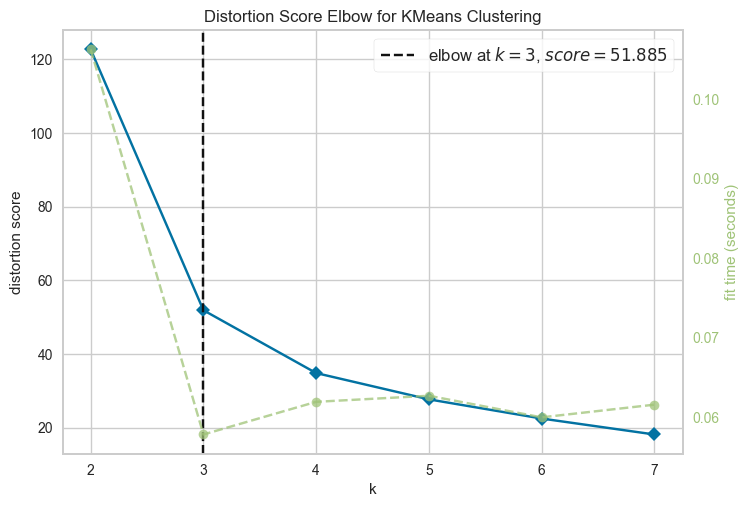

In [16]:
# Calling the elbow_visualizer using the distortion metric
elbow_visualizer(kmeans, rfm_scaled, metric='distortion', show_value=True)

- The distortion score (blue line) decreases as the number of clusters increases, which is expected because more clusters generally mean better fit to the data.

- The “elbow point” is the value of k where the distortion score stops decreasing sharply and starts to level off. This point represents a good balance between model complexity and fit quality.

- In this case, the elbow is at k = 3, with a distortion score of 51.885. This suggests that 3 clusters is the optimal number for this dataset.

,k-Value,Silhouette Score,Times (second)
0,2,0.662510,0.061003
1,3,0.718923,0.059140
2,4,0.633617,0.059195
3,5,0.624851,0.061688
4,6,0.629090,0.061444
5,7,0.475234,0.062127


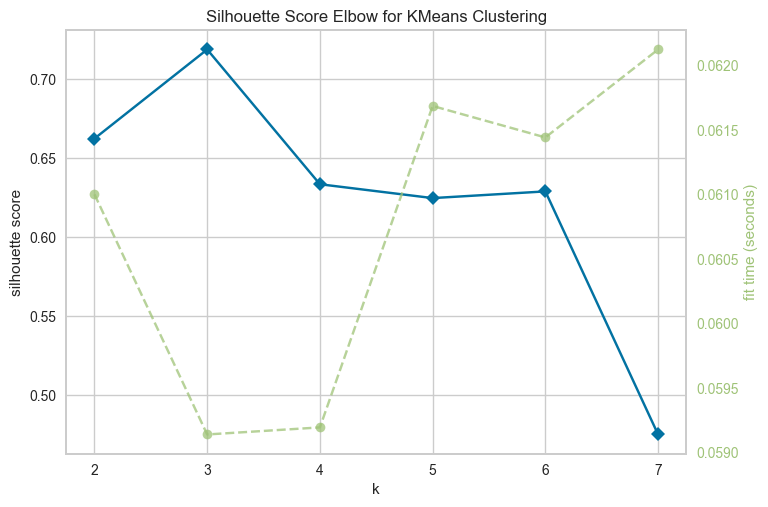

In [17]:
# Calling the elbow_visualizer using the silhouette metric
elbow_visualizer(kmeans, rfm_scaled, metric='silhouette', locate_point=False, show_value=True)

- The silhouette score (blue line) measures how well data points fit within their assigned cluster, with values ranging from -1 to 1. A higher score indicates better-defined and more well-separated clusters.

- The highest silhouette score is observed at k = 3, suggesting that using 3 clusters provides the best overall cluster separation and cohesion for this dataset.

- After k = 3, the silhouette score gradually decreases, and drops sharply at k = 7, indicating weaker clustering performance with more clusters.

### **Visualize Cluster**

In [18]:
best_clusters = 3

model = KMeans(n_clusters=best_clusters, random_state=42)

kmeans_cluster = rfm_data[['vehicle_id', 'recency', 'frequency', 'monetary']]

start_time = time.time()
kmeans_cluster['cluster'] = model.fit_predict(rfm_scaled)
end_time = time.time()
kmeans_time= end_time - start_time

kmeans_cluster['cluster'].value_counts()

1    64
0    13
2     7
Name: cluster, dtype: int64

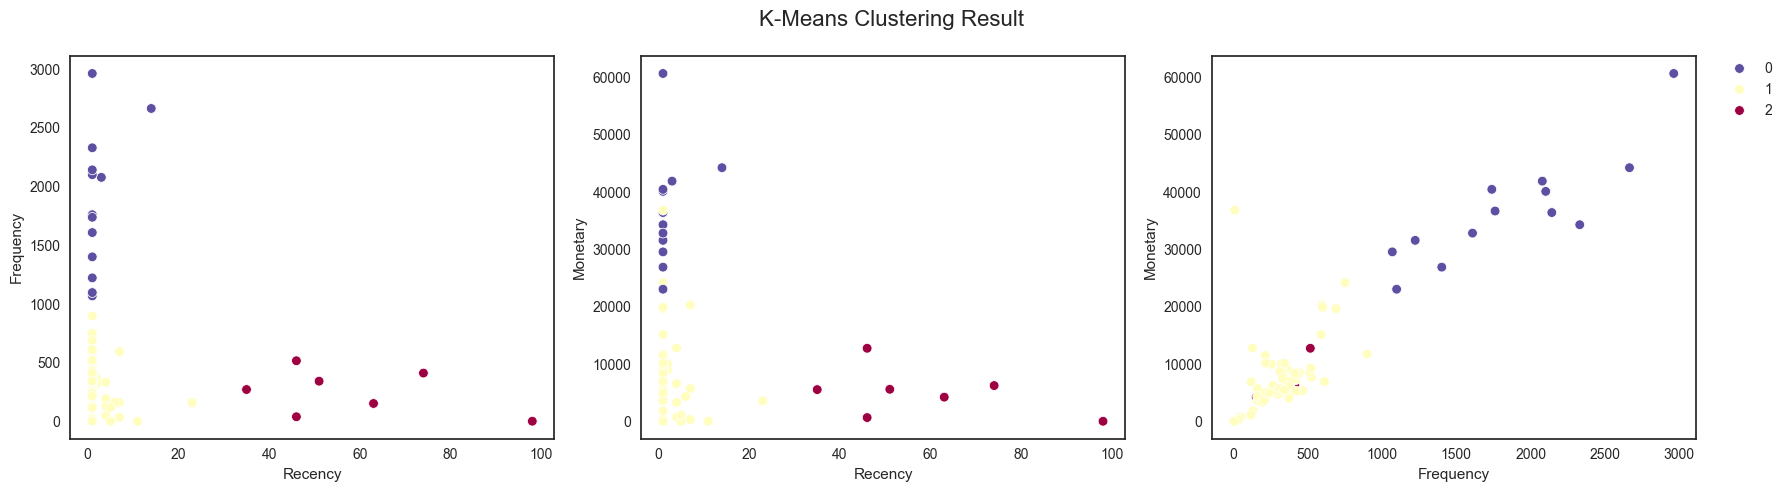

In [19]:
plot_cluster(data=kmeans_cluster, cluster='cluster', suptitle='K-Means Clustering Result')

In [20]:
plot_cluster(data=kmeans_cluster, cluster='cluster', plot_3d=True, suptitle='K-Means Clustering Result 3D')

The segmentation into three clusters using the K-Means Clustering method appears to be effective, with clear differentiation between clusters, such as:

- **`Cluster 0 (Dark Blue) - Power Riders`**:
Vehicles with low recency (used recently), high frequency, and high usage duration. Riders are very active and consistent. Potentially loyal or part of the main user in business.

- **`Cluster 1 (Pink/Red) - Active Riders`**:
Rider who use vehicles regularly. May be responsive to promotion or reminder.
→ Represent average or moderately active users.

- **`Cluster 2 (Yellow)  - Inactive Riders`**:
Vehicles with high recency (not used recently), low frequency, and low usage duration. Passive riders or almost inactive. Can be a target of reactivation or evaluation of Churn.

In [21]:
# Calculate the Silhouette score for K-Means clustering
kmeans_silhouette_score = silhouette_score(rfm_scaled, kmeans_cluster['cluster'])

# Print the Silhouette score
print(f"K-Means Clustering Times: {round(kmeans_time, 3)} Seconds")
print(f"K-Means Clustering Silhouette score: {kmeans_silhouette_score}")

K-Means Clustering Times: 0.066 Seconds
K-Means Clustering Silhouette score: 0.7189228588296148


## **Agglomerative Clustering**
---

Agglomerative Clustering is a hierarchical clustering algorithm used in data analysis and data mining to group similar data points into clusters or groups. This algorithm follows a "bottom-up" or "agglomerative" approach, where it starts with each data point as its own cluster and then iteratively merges clusters together based on their similarity until a single main cluster is formed.

Here are the key steps in Agglomerative Clustering:

- **Initialization**: Each data point is initially treated as a single cluster, so the number of clusters is equal to the number of data points.

- **Similarity Measurement**: The algorithm calculates the similarity or dissimilarity between clusters. Various distance metrics, such as Euclidean distance, Manhattan distance, or other similarity measures, can be used to quantify the dissimilarity between clusters.

- **Cluster Merging**: The two clusters that are most similar to each other, based on the chosen similarity measure, are merged into a single cluster. This process continues iteratively until only one primary cluster remains. The order of merging is typically recorded, allowing the creation of a hierarchical structure or dendrogram.

- **Dendrogram**: The hierarchical structure of clusters is often represented as a dendrogram, which is a tree-like diagram that shows the sequence of cluster merges. This dendrogram can be useful for visualizing the hierarchy of clusters and for determining the optimal number of clusters at various levels of granularity.

- **Stopping Criteria**: The clustering process stops when certain stopping criteria are met. Common stopping criteria include reaching a predetermined number of clusters or when the dissimilarity between clusters exceeds a certain threshol

### **Tuning and Evaluation**

Just like with K-Means, we use the Elbow Method and Silhouette Score to find the best number of clusters for Agglomerative Clustering. But with Agglomerative Clustering, we also use a dendrogram to help decide.

A dendrogram is a chart that shows how the clusters are combined step by step. It helps us see where the biggest jumps or changes happen during the merging process. This visual tool gives extra clues about the most natural number of clusters, making it easier to choose the right value for k.

Sample allocation in the context of the Agglomerative Clustering algorithm is an approach used to address computational challenges when dealing with a large amount of data. Our data consists of 96,000 rows, which can consume a significant amount of computational resources and time to be processed by the Agglomerative Clustering algorithm.

,k-Value,Distortion Score,Times (second)
0,2,122.957670,0.001086
1,3,54.228596,0.001004
2,4,41.264262,0.001426
3,5,31.754244,0.001414
4,6,23.457386,0.001037
5,7,19.460048,0.001032


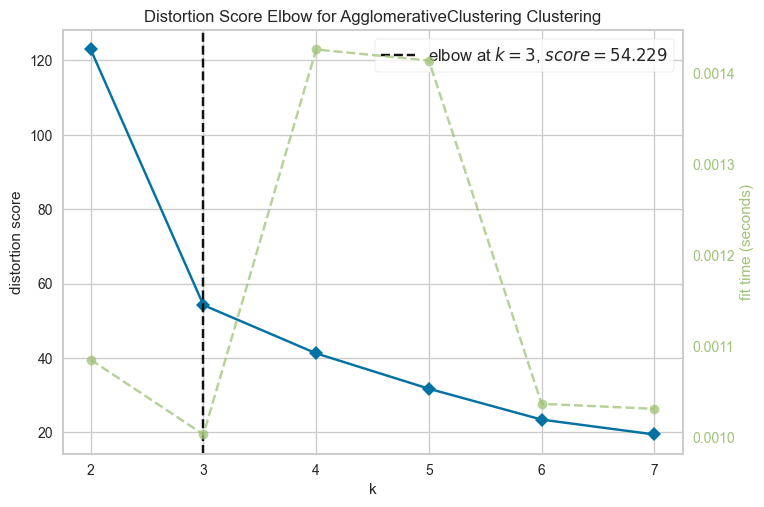

In [22]:
agglomerative= AgglomerativeClustering(linkage='ward', compute_distances=True, compute_full_tree=True)

elbow_visualizer(agglomerative, rfm_scaled, metric='distortion', show_value=True)

- The distortion score (blue line) drops sharply from k=2 to k=3, and then the decline slows down.

- The “elbow point” appears at k = 3, meaning this is the optimal number of clusters.

- After k = 3, adding more clusters only gives small improvements, so 3 is a good balance between simplicity and performance.

,k-Value,Silhouette Score,Times (second)
0,2,0.667533,0.001247
1,3,0.703856,0.002495
2,4,0.591078,0.001142
3,5,0.588515,0.001096
4,6,0.586285,0.001001
5,7,0.586637,0.001158


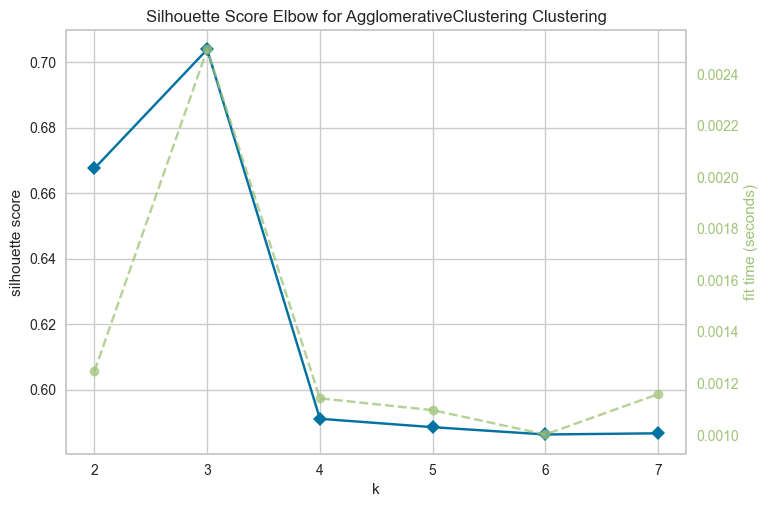

In [23]:
# Calling the elbow_visualizer using the silhouette metric
elbow_visualizer(agglomerative, rfm_scaled, metric='silhouette', locate_point=False, show_value=True)

- The highest silhouette score is at k = 3, with a value of around 0.71, which indicates well-separated and clearly defined clusters.

- After k = 3, the silhouette score drops significantly, especially at k = 4 and 5, meaning the quality of clustering decreases with more clusters.

- The best number of clusters is 3, because it gives the clearest and strongest grouping. More clusters make the grouping worse.

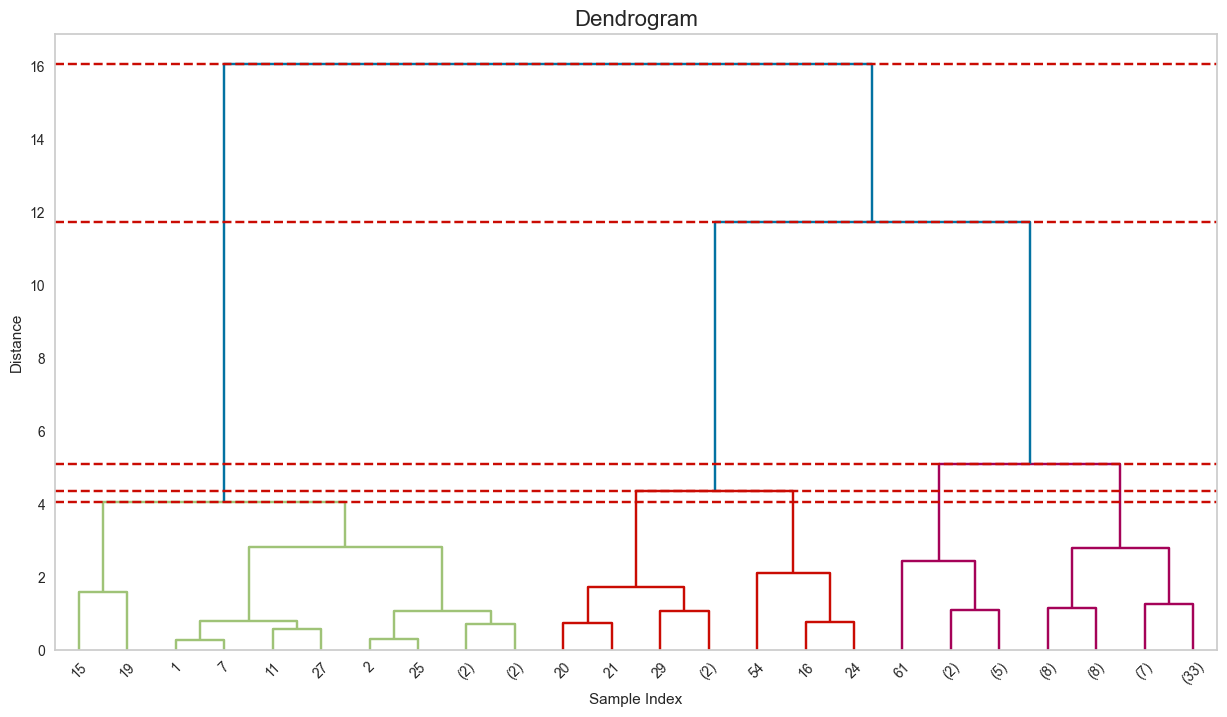

In [24]:
# Calculating linkage matrix
linkage_matrix = linkage(rfm_scaled, method='ward')

# Plotting dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=4)
plt.axhline(y=16.05, color='r', linestyle='--')
plt.axhline(y=11.73, color='r', linestyle='--')
plt.axhline(y=5.1, color='r', linestyle='--')
plt.axhline(y=4.35, color='r', linestyle='--')
plt.axhline(y=4.07, color='r', linestyle='--')
plt.title('Dendrogram', fontsize=16)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.grid()
plt.show()

- **2 Clusters**: The distance between the two main clusters is approximately 4.32 (16.05 - 11.73). This indicates a strong separation between two distinct customer groups, likely reflecting major differences in their RFM profiles.

- **3 Clusters**: The distance between the second and third clusters is about 6.63 (11.73 - 5.10). This relatively large gap suggests that the third cluster adds valuable segmentation, highlighting another distinct customer group with unique behaviors.

- **4 Clusters**: The separation distance between the third and fourth clusters is around 0.75 (5.10 - 4.35). This small gap shows that adding a fourth cluster results in a minor increase in segmentation and may not contribute significant new insights.

- **5 Clusters**: The distance for the fifth cluster is only about 0.28 (4.35 - 4.07), indicating a very slight difference. This suggests that introducing a fifth cluster does not provide meaningful additional separation.

Based on the dendrogram distances, 3 clusters is the most suitable choice. It offers a balance between meaningful segmentation and simplicity.

### **Visualize cluster**

In [25]:
best_clusters=3

# Initialize AgglomerativeClustering model with 4 Cluster
agglomerative = AgglomerativeClustering(n_clusters=best_clusters, linkage='ward', compute_distances=True, compute_full_tree=True)

# Create a copy of the 'sample_cleaned' DataFrame to avoid modifying the original data
agglo_cluster = rfm_data.copy()

# Fit the AgglomerativeClustering model to the scaled data and assign cluster labels to the 'cluster' column
start_time = time.time()
agglo_cluster['cluster'] = agglomerative.fit_predict(rfm_scaled)
end_time = time.time()
agglo_time= end_time - start_time

# Count the number of data points in each cluster and display the counts
agglo_cluster['cluster'].value_counts()

0    64
1    12
2     8
Name: cluster, dtype: int64

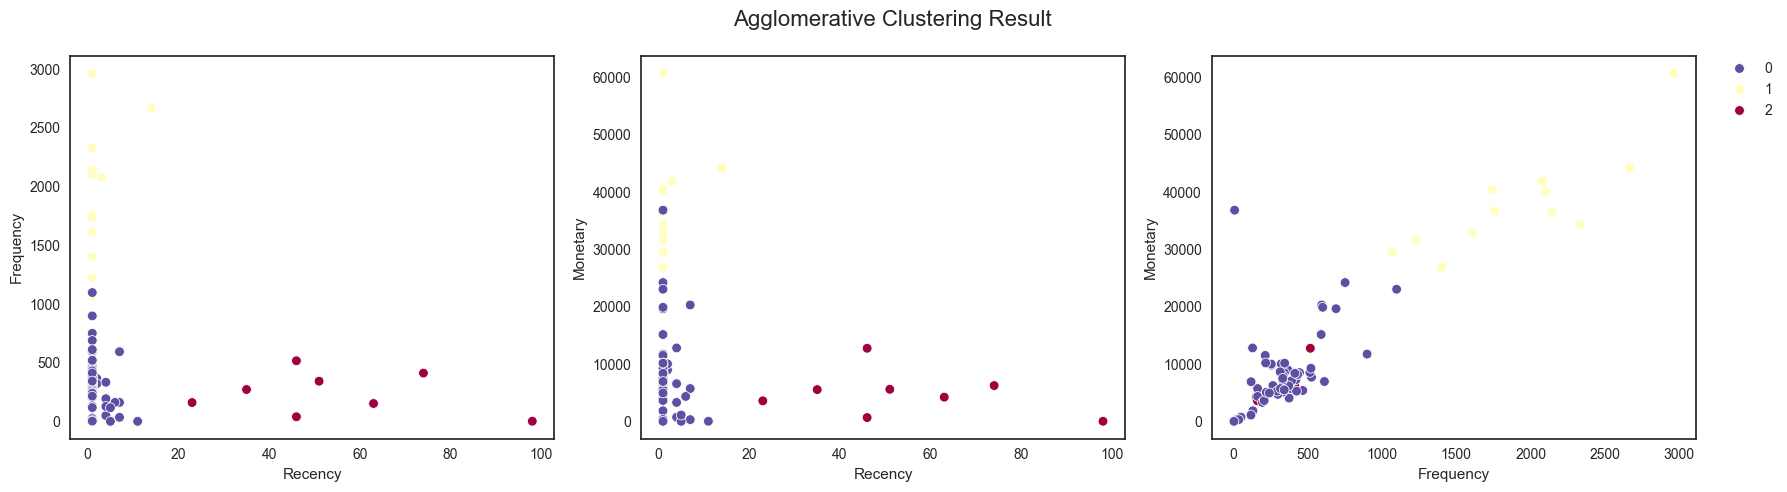

In [26]:
# Plot Agglomerativeclustering results
plot_cluster(data=agglo_cluster, cluster=agglo_cluster['cluster'], suptitle='Agglomerative Clustering Result')

In [27]:
# Plot 3D Agglomerativeclustering results
plot_cluster(data=agglo_cluster, cluster=agglo_cluster['cluster'], plot_3d=True, suptitle='Agglomerative Clustering Result 3D')

The segmentation into three clusters using the Agglomerative method appears to be effective, with clear differentiation between clusters, such as:

- **`Cluster 1 (Pink) - Power Riders`**:
This cluster consists of riders with low recency, high frequency, and high monetary value. These are your most active and engaged rider, likely to have subscribed passengers or loyal customers who rely heavily on  platform.

- **`Cluster 0 (Pink/Red) - Active Riders`**:
Riders in this group show moderate recency, moderate frequency, and moderate spending. These are irregular but consistent rider not highly engaged, but still active.

- **`Cluster 2 (Yellow)  - Inactive Riders`**:
Riders in this cluster have high recency, low frequency, and low monetary value. This group likely consists of inactive users, occasional riders, or those who may have discontinued using the service altogether. This segment may include one-time users, churned riders, or those exploring other transportation options. 

In [28]:
# Calculate the Silhouette score for Agglomerative clustering
agglo_silhouette_score = silhouette_score(rfm_scaled, agglo_cluster['cluster'])

# Print the Silhouette score
print(f"Agglomerative Clustering Times: {round(agglo_time, 3)} Seconds")
print(f"Agglomerative Clustering Silhouette score: {agglo_silhouette_score}")

Agglomerative Clustering Times: 0.001 Seconds
Agglomerative Clustering Silhouette score: 0.7038555620635106


# **Summary**

In [29]:
pd.DataFrame({
        'Model': ['K-Means Clustering', 'Agglomerative Clustering'],  
        'Silhouette Score': [kmeans_silhouette_score.round(3), agglo_silhouette_score.round(3)],  
        'Training Time(s)': [round(kmeans_time, 3), round(agglo_time, 3)]  
    })

,Model,Silhouette Score,Training Time(s)
0,K-Means Clustering,0.719,0.066
1,Agglomerative Clustering,0.704,0.001


Both K-Means and Agglomerative Clustering methods, along with evaluation metrics such as the Elbow Method, Silhouette Score, and Dendrogram Analysis, consistently identify three optimal rider segments. This agreement across methods indicates a stable and well-defined clustering structure in the data, allowing for confident interpretation and strategy development.

- **`Power Riders Cluster`**:
    
    - Characteristics:

        - Low recency: These riders have used the platform very recently, indicating high engagement.

        - High frequency: They take trips frequently and consistently over time.

        - High monetary: They tend to spend more time using the platform or take longer trips, signaling heavy usage.

        - These riders likely have subscribed passengers or loyal customers who rely heavily on platform.

    - **`Insight & Strategi`**:

        - Introduce a tiered loyalty program offering benefits such as discounted services, priority access, or bonus points for consistent use.

        - Provide scheduled maintenance packages or alerts to ensure their vehicles remain in good condition due to high usage.

        - Send targeted educational content (e.g., on vehicle care or safety) to reduce downtime due to mechanical issues.

        - Maintain high service quality and minimize disruptions to keep satisfaction levels high.

- **`Active Riders Cluster`**:  
    - Characteristics:

        - Moderate recency: They have used the platform relatively recently, though not as recently as Power Riders.

        - Moderate frequency: Their trip activity is steady but not intensive.
        
        - Moderate usage value: Their overall usage is balanced, indicating potential to increase or decrease based on platform experience and incentives.


    - **`Insight & Strategi`**:

        - Implement targeted promotions, such as time-limited offers bonus point, to encourage more frequent use.

        - Targeted promotions, reminders, or content recommendations

        - Monitor behavior to detect shifts, whether toward higher engagement or signs of disengagement and respond proactively.


- **`Inactive Riders Cluster`**:
    - Characteristics:

        - High recency: These users haven't used the platform for a long time, indicating disengagement.

        - Low frequency: Very few trips logged.

        - Low trip value: Their overall platform use is minimal.


    - **`Insight & Strategi`**:

        - These users are at risk of churn, Investigate if their vehicle is inactive due to damage, disuse, or lack of interest.

        - Send reactivation offers or surveys to understand their situation.

        - Make loyalty point bonus and reminders to bring them back

        - Offer a big discount for checking the vehicle if there really have a problem

